In [1]:
import networkx as nx
import numpy as np
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import datetime
#from minepy import MINE

In [2]:
from preprocessing_net import get_cyclic_net
from mutual_info import *
from nrmse_calc import nrmse, nrmse_n
from r_to_python import *

changes


In [3]:
#imports
import entropy_estimators as ee
import scipy.spatial as ss
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import scipy

In [4]:
#ESN_class.py imports
import random as rand

In [6]:

u=np.vstack((1,2))
np.vstack((1,u))

array([[1],
       [1],
       [2]])

In [51]:
#@jitclass(spec,nopython=True)
class ESN(object):
    def __init__(self, net, in_size, out_size, spectral_radius):
        self.net=net
        self.res_size= len(net.nodes())
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=None
        self.W=None
        self.Win=dict()
        self.Wout=None
        self.X=dict()
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0_e=np.random.rand(self.res_size)
        #NO SE SI ESTABA EL 10
        self.x0=np.insert(np.random.rand(self.res_size),0,[1.0,1.0,1.0])
        self.u0=0
        self.decay=np.random.gamma(5.22,0.017,size=self.res_size).reshape((self.res_size,1))
        self.u=None
        self.x_act=None
        self.dict_pos=None
        self.u_dict=dict()
        self.x_act_dict=dict()

   
    def build_adj_weighted_matrix(self,mapping):
        #NETWORK v2.0
        net=nx.relabel_nodes(self.net,mapping,copy=True)
        dict_pos=dict((node,pos) for (pos,node) in enumerate(net.nodes()))
        for edge in net.edges(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= np.random.uniform(0,1) -0.5
            elif mode== "-":
                net[source][target]["weight"]= np.random.uniform(-1,0) -0.5
            elif mode== 0:
                net[source][target]["weight"]= np.random.uniform(-1,1)-0.5
        
        return nx.to_numpy_matrix(net),dict_pos
    
    def input_matrix_just_genes_GOterm(self,Win,GOterms,GO_id_map,mapping,i_scaling,tau_list):
        print(i_scaling)
        Win={} 
        Win[sum(tau_list)]=np.zeros((self.res_size,1+len(tau_list)))
        for index, GOterm in enumerate(GOterms):
            print(GOterm, tau_list[index])
            Win[tau_list[index]]=np.zeros((self.res_size,2))
            for gene in GO_id_map[GOterm]:
                Win[tau_list[index]][self.dict_pos[gene],1]=(np.random.uniform()) *i_scaling[index]
                Win[tau_list[index]][self.dict_pos[gene],0]=(np.random.uniform()) *beta_scaling[index]
                #Win[tau_list[index]][self.dict_pos[gene],index+1]=(np.random.uniform()) *i_scaling[index]
                Win[sum(tau_list)][self.dict_pos[gene],0]=(np.random.uniform()) *beta_scaling[index]
                Win[sum(tau_list)][self.dict_pos[gene],index+1]=(np.random.uniform()) *i_scaling[index]
        print([Win[taau][3,0] for taau in Win])
        return Win
    
    def initialize(self,i_scaling,beta_scaling,mapping,GOterms,GO_id_map,tau_list): 
        np.random.seed(42)
        print("seed puesta")
        print("factor i= {}".format(i_scaling))
        print("factor beta={}".format(beta_scaling))
        
        self.W0, self.dict_pos=self.build_adj_weighted_matrix(mapping)
        self.res_size= self.W0.shape[0]
        self.W0 = np.squeeze(np.asarray(self.W0)) 
        radius = np.max(np.abs(np.linalg.eigvals(self.W0)))
        self.W= (self.spectral_radius/radius)*self.W0
        
        
        self.Win=self.input_matrix_just_genes_GOterm(self.Win,GOterms,GO_id_map,mapping,i_scaling,tau_list)
        return self.W
    
    
    def dx_act_dt(self, x,u,tau):
        x=x.reshape(self.res_size,1)
        x_act=self.decay*0.5*(np.tanh( np.dot( self.Win[tau], np.vstack((1,u)) ) + np.dot( self.W, x ) )+1) - (self.decay * x)
        return x_act.reshape(self.res_size)
    
    def colored_noise_euler_integration(self, x_0, u_0, t_stop, tau_list,dt=0.001):
        
    
        x={}
        u={}
        t = np.linspace(0, t_stop, int(t_stop/dt))
        
       
        
        for index,tau in enumerate(tau_list):
            #np.random.seed(2+index)
            c=(1/tau)**2
            mu=np.exp(-dt/tau)
            sigma= sqrt( ((c * tau)/2) * (1-mu**2) )
            print("Generating {} noise".format(tau))
            x[tau]=np.zeros((len(t),self.res_size))
            x[tau][0,:]=x_0
            u[tau] = u_0 * np.ones_like(t)         
            for i in np.arange(0, len(t) - 1):
                u[tau][i+1] = u[tau][i]* mu + sigma * np.random.normal()
                x[tau][i+1,:] = x[tau][i,:] + dt * self.dx_act_dt(x[tau][i,:], u[tau][i],tau)
        
        print("Generating {} noise".format(sum(tau_list)))
        x[sum(tau_list)]=np.zeros((len(t),self.res_size))
        x[sum(tau_list)][0,:]=x_0
        for i in np.arange(0, len(t) - 1):
            u_concat=np.vstack(([u[tau][i] for tau in tau_list]))
            x[sum(tau_list)][i+1,:] = x[sum(tau_list)][i,:] + dt * self.dx_act_dt(x[sum(tau_list)][i,:], u_concat,sum(tau_list))
        return u,x
    

    
    def collect_states_derivative(self, init_len, train_len, test_len,tau_list,dt=0.001):
        t_stop=train_len+test_len
        indexes=[int(t/dt) for t in range(0,t_stop)]
       
        print("Collecting states with noise input...")
        u, x_act=self.colored_noise_euler_integration(self.x0_e, self.u0, t_stop, tau_list,dt)
        self.u_dict= {tau:u_tau[indexes] for tau,u_tau in u.items() }
        u=None
        self.x_act_dict={tau:x_tau[indexes] for tau,x_tau in x_act.items() }
        x_act=None
   
    

    def calculate_weights_readout(self,init_len, train_len, n, res_indexes,tau_train,tau_test, tau_list,beta=1e-8):
        print("{} a la que se esta entrando".format(tau_train))
        Y=np.array([self.u_dict[tau_train][init_len-n:train_len-n]])
        #indexes=list(range(0,self.in_size+1))+[index+self.in_size+1 for index in res_indexes]
        #indexes=[index+self.in_size+1 for index in res_indexes]
        print("xact entreno {}".format(sum(tau_list)))
        X=self.x_act_dict[sum(tau_list)][init_len-n:train_len-n,res_indexes].T
        print(X.shape)
        X_T=X.T
        Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(X,X_T) + beta * np.eye(len(res_indexes)))) #w= y*x_t*(x*x_t + beta*I)^-1
        return Wout
    
    def run_predictive_readout(self, test_len, train_len,indexes,Wout, tau_test):
        self.Win=None
        Y = np.zeros((test_len))
        for t in np.arange(train_len,train_len+test_len):
            #x_concat=self.x_act_dict[tau_test][t,indexes].reshape(self.x_act_dict[tau_test][t,indexes].shape[0],1)
            y = np.dot( Wout, self.x_act_dict[tau_test][t,indexes] )
            Y[t-train_len] = y
        return Y
    
    def run_simulation_readout(self,readout_dict,readout_pos,init_len,train_len,test_len,n,tau_train,tau_test,tau_list,beta=1e-8):
        self.Y = np.zeros((len(readout_dict),test_len))
        for gene_readout in readout_dict:
            print("{} output being calculated".format(gene_readout))
            indexes=[self.dict_pos[gene_res] for gene_res in readout_dict[gene_readout]]
            
            print("{} training to noise and neuron activation with tau_train= {}".format(gene_readout,tau_train))
            Wout=self.calculate_weights_readout(init_len, train_len, n, indexes, tau_train,tau_test,tau_list,beta=1e-8)
      
            print("{gene} testing with neuron activation from tau_test= {tau} (input tau {tau})".format(gene=gene_readout,tau=tau_test))
            Y=self.run_predictive_readout(test_len, train_len,indexes,Wout,tau_test)
            self.Y[readout_pos[gene_readout],:]=Y
            
        return self.Y
    
   


In [7]:
tau_list=[5,10]
u={5:2,10:7}
np.vstack(([u[tau] for tau in tau_list]))

array([[2],
       [7]])

In [8]:
##################################################################################

In [9]:
gene_readout="g"
tau_test=10
print("{gene} testing with neuron activation from tau_test= {tau} (input tau {tau})".format(gene=gene_readout,tau=tau_test))

g testing with neuron activation from tau_test= 10 (input tau 10)


In [10]:
#                                   FUNCTIONS                                    #

In [11]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    result=result[int(result.size/2):]
    return result/result[0]

In [12]:
def test(directory,file_path, in_size, spectral_radius, i_scaling,beta_scaling,GOterms,n, noise, euler=True, save=False, notebook=True):
    #init
    print(file_path)
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]

    
    print("Running network...")
    G=get_cyclic_net(os.path.join(directory, file_path))
    
    GO_id_map=get_r_dictionaries("test.txt",mapping=False)
    edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
    mapping=mapping_relabel_function(G,edgeid_ezid_map)
   
    for key,values in GO_id_map.items():
        GO_id_map[key]=set([mapping[value] for value in values])

    
    #Run network
    net=ESN(G,in_size,1,spectral_radius)                              
    net.initialize(i_scaling,beta_scaling,edgeid_ezid_map,GOterms,GO_id_map)
    print("SR", net.spectral_radius)
    
    #Choose input and collect states
    print(net.Win[65,])
    print(np.where(net.Win!=0))
    net.collect_states_derivative_OLD(initLen, trainLen, testLen, euler, noise,dt=0.001)
    

    #train 
    print("Training network...")
    print("n=",n)
    net.calculate_weights_derivative_OLD(initLen,trainLen,n)
    print("%d trained to n =%d delay FINISHED" %(net.res_size,n))
    net.run_predictive_derivative_OLD(testLen,trainLen)
    
    if notebook and noise:
        print("Autocorrelation of generated noise")
        autocorr=autocorrelation(net.u)
        exponential_fitting(autocorr,exp_func)
            
        print("Autocorrelation of predicted noise")
        autocorr=autocorrelation(net.Y.reshape(net.Y.shape[1]))
        exponential_fitting(autocorr,exp_func)
        folder="noise"
        figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        plot_temporal_lines(net.u,net.Y, n,testLen-initLen,filename, tau, folder, save)
            
        figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        plot_temporal_lines(net.u,net.Y, n, 50,filename, tau, folder ,save)
    
    close('all')    
    
    ## Mi in Go term
    #initialize arrays
    
    
    #calculating Mi
    mi_go_by_gene={}
    mi_not_go=[]
    for gene,pos in net.dict_pos.items():
        mi=calc_MI_binning(net.u[testLen:testLen+miLen], net.x_act[testLen:testLen+miLen,pos])
        if gene in set.union(*GO_id_map.values()):
            mi_go_by_gene[(gene,G.degree(gene))]=mi
        else:
            mi_not_go.append(mi)
                
   
    #means across nodes
    print("Mi not go")
    print(np.mean(mi_not_go))
    print()
    print("Mi go")
    for gene,mi in mi_go_by_gene.items():
        print(gene)
        print(mi,"\n")
     

In [13]:
def test_readout(directory,file_path,in_size, tau_list,tau_test_list,tau_train,spectral_radius, i_scaling,beta_scaling,GOterms,readout_dict,n, noise, euler=True, save=False, notebook=True):
    #init
    print(file_path)
    print(miLen)
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]

    
    print("Running network...")
    G=get_cyclic_net(os.path.join(directory, file_path))
    
    GO_id_map=get_r_dictionaries("test.txt",mapping=False)
    edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
    mapping=mapping_relabel_function(G,edgeid_ezid_map)
   
    for key,values in GO_id_map.items():
        GO_id_map[key]=set([mapping[value] for value in values])

    
    #Run network
    net=ESN(G,in_size,1,spectral_radius)                              
    net.initialize(i_scaling,beta_scaling,edgeid_ezid_map,GOterms,GO_id_map,tau_list)
    print("SR", net.spectral_radius)
    
    readout_pos={gene:pos for pos,gene in enumerate(all_readout.keys())}
    #Choose input and collect states
    print("Collecting states")
    net.collect_states_derivative(initLen, trainLen, testLen, tau_list,dt=0.001)
   
    if notebook and noise:
        print("Autocorrelation of generated noise")
        for tau in net.u_dict:
            print(tau)
            autocorr=autocorrelation(net.u_dict[tau])
            exponential_fitting(autocorr,exp_func)
            show()
            
    #train 
    for tau_test in tau_test_list:
        print("El traning se hace para {} y en el testing introducimos las taus en {}".format(tau_train,tau_test))
        net.run_simulation_readout(readout_dict,readout_pos,initLen,trainLen,testLen,n,tau_train,tau_test,tau_list,beta=1e-8)
    ## Mi in Go term
    #initialize arrays
        mi_go_by_gene={}
        nrmse_go_by_gene={}
        mi_not_go=[]
    
    #calculating Mi
        print("MI")
        for gene,pos in readout_pos.items():
            print(gene)
            for tau in tau_list:
                print("El input al que comparamos es tau={}".format(tau))
                plot(net.u_dict[tau][trainLen-n:trainLen+miLen-n])
                plot(net.Y[pos,0:miLen])
                show()
                print(miLen)
                mi=calc_MI_binning(net.u_dict[tau][trainLen-n:trainLen+miLen-n], net.Y[pos,0:miLen])
                nrmse_val=nrmse(net.u_dict[tau][trainLen-n:trainLen+errorLen-n], net.Y[pos,0:errorLen])
                print(mi)
                print(nrmse_val)
                print()
                if tau==tau_train:
                    mi_go_by_gene[gene]=mi
                    nrmse_go_by_gene[gene]=nrmse_val
    return net,mi_go_by_gene,nrmse_go_by_gene


In [14]:
def exp_func(x, a, b,c):
    return a * np.exp(-1/b * x)+c

In [15]:
def exponential_fitting(x, func,p0=None,start_point=0,MI=False):
    if MI: #x is MI
        xdata=np.array(list(x.keys())[start_point:])
        ydata=np.array(list(x.values())[start_point:])
    else: #x is autocorr
        a=x[:np.argmax(x<0)]
        ydata=a
        xdata=np.arange(a.shape[0])
    popt, pcov = curve_fit(func, xdata, ydata,p0)
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot(xdata, ydata, '-o', label='data')
    plot(xdata, func(xdata, *popt), 'r-', label="fit")
    #plot(xdata, exp_func(xdata, popt[0],tau,popt[2]), 'b-', label="expected fit")
    xlabel('n',fontsize=20)
    ylabel('MImax',fontsize=20)
    legend(loc=1, prop={'size': 20})
    print(popt)
    return popt,xdata,ydata

In [16]:
##################################################################################

In [17]:
#                                  PARAMETERS                                    #

In [70]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=10000
testLen=5000
miLen=990
initLen=200
subsetLen=5200
m=10
startLen=(subsetLen-initLen)*m

i_scaling=[1,1]
beta_scaling=[0.1,0.1]

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']


In [23]:
##################################################################################

In [24]:
#                                   TESTEOS                                      #

In [25]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_ENCODE.csv"))
len(G.nodes())

207

In [26]:
#TESTEO adjacency matrix
net=ESN(G,1,1,1)
net.res_size

207

In [27]:
#TESTEO r to python
GO_id_map=get_r_dictionaries("test.txt",mapping=False)
print(GO_id_map.keys())
print()
## id to ENTREZ id
edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
mapping=mapping_relabel_function(G,edgeid_ezid_map)

for key,values in GO_id_map.items():
    GO_id_map[key]=set([mapping[value] for value in values])

dict_keys(['GO:0070317', 'GO:0051591'])



In [28]:
GO_id_map

{'GO:0051591': {'FOS', 'FOSL1', 'JUN', 'JUNB', 'JUND', 'SREBF1', 'STAT1'},
 'GO:0070317': {'BRCA1', 'E2F1', 'E2F6', 'MAX', 'SUZ12'}}

In [29]:
#TESTEO initialize
tau_list=[5,10]
net.initialize([1,1],beta_scaling,mapping,['GO:0070317',"GO:0051591"],GO_id_map,tau_list)
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))
for tau in tau_list +[sum(tau_list)]:
    print(np.where(net.Win[tau]!=0))
print(net.Win)


seed puesta
factor i= [1, 1]
factor beta=[0.1, 0.1]
[1, 1]
GO:0070317 5
GO:0051591 10
(207, 207)
1.0
(array([ 3,  3,  5,  5, 26, 26, 59, 59, 86, 86]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))
(array([ 62,  62,  63,  63,  64,  64,  74,  74, 120, 120, 144, 144, 166, 166]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))
(array([  3,   3,   5,   5,  26,  26,  59,  59,  62,  62,  63,  63,  64,
        64,  74,  74,  86,  86, 120, 120, 144, 144, 166, 166]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       2]))
{15: array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.93998093e-04,   9.51811785e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.05841210e-02,   1.11919619e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [

In [26]:
net=None

In [27]:
##################################################################################

In [28]:
#                             RESULTS  NOISE                                         #

In [30]:
# SINGLE FILE:
file=csv_files[0]

## N range
i_max=100
n_max=100
n_range=np.array(range(n_max))


#parameters
file

'network_edge_list_ENCODE.csv'

In [26]:
# COLORED NOISE

In [27]:
## Parameters
tau=10
c_n=(1/tau)**2
c_n

0.010000000000000002

In [32]:
## SIMULACIONES CON READOUT

In [33]:
##Load readout dictionaries

In [32]:
GO_005= np.load('GO_005.npy').item()
GO_007= np.load('GO_007.npy').item()
GO_007_005= np.load('GO_007and005.npy').item()

In [33]:
all_readout={**GO_005,**GO_007,**GO_007_005}

In [34]:
GO_007

{'ABCA3': {'CTCF', 'CTCFL', 'E2F6', 'MAX', 'NRF1'},
 'BRD9': {'E2F1', 'E2F4', 'GABPA', 'MYC', 'SIN3A'},
 'STYXL1': {'BRCA1', 'ELF1', 'ETS1', 'GABPA', 'ZBTB33'}}

In [35]:
all_readout

{'ABCA3': {'CTCF', 'CTCFL', 'E2F6', 'MAX', 'NRF1'},
 'ACAD9': {'ATF3', 'E2F6', 'JUND', 'MAX', 'NRF1'},
 'ALDH1A1': {'CTCF', 'JUN', 'MAX', 'RAD21', 'USF1'},
 'BRD9': {'E2F1', 'E2F4', 'GABPA', 'MYC', 'SIN3A'},
 'C20orf111': {'CTCF', 'JUND', 'NRF1', 'RAD21', 'SIN3A'},
 'STYXL1': {'BRCA1', 'ELF1', 'ETS1', 'GABPA', 'ZBTB33'},
 'TMEM14C': {'MAFF', 'MAFK', 'NR3C1', 'SP1', 'SREBF1'},
 'ZNF775': {'FOS', 'NFYA', 'NFYB', 'SREBF1', 'TCF4'}}

In [32]:
##simulacion

In [33]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[1,10]
tau_test=[1,10,sum(tau_list)]
tau_train=1
 

In [40]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,0, noise=True, euler=True, save=False, notebook=True)


network_edge_list_ENCODE.csv
500
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 1
GO:0070317 10
SR 0.95
Generating 1 noise


KeyboardInterrupt: 

In [ ]:
##SIMULACION 1

In [35]:
i_scaling=[1,1]
beta_scaling=[0.01,0.01]
tau_list=[20,10]
tau_test=[20]
tau_train=20
 

seed: 0
network_edge_list_ENCODE.csv
500
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.01, 0.01]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.5
Generating 20 noise
Generating 10 noise
Generating 30 noise
Autocorrelation of generated noise
20
[  1.03281951  29.62593263  -0.06836178]


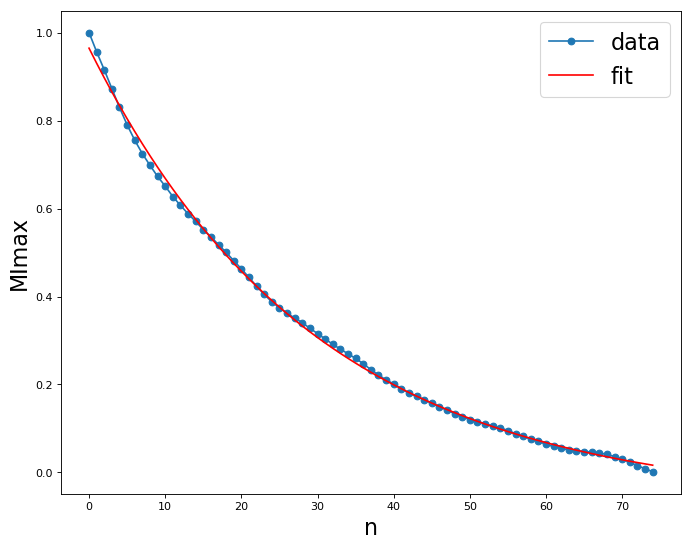

10
[ 1.01637122  8.71908207  0.01307606]


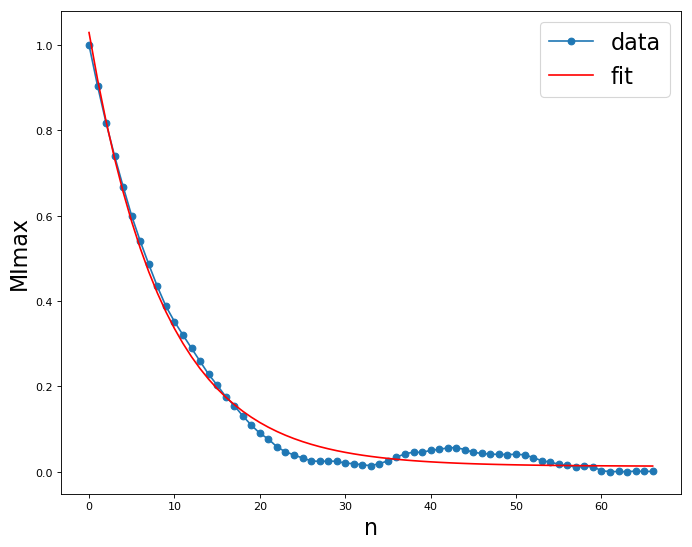

El traning se hace para 10 y en el testing introducimos las taus en 10
APOM output being calculated
APOM training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(10, 1800)
APOM testing with neuron activation from tau_test= 10 (input tau 10)
TUBB1 output being calculated
TUBB1 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(10, 1800)
TUBB1 testing with neuron activation from tau_test= 10 (input tau 10)
SPHK1 output being calculated
SPHK1 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(10, 1800)
SPHK1 testing with neuron activation from tau_test= 10 (input tau 10)
MI
APOM
El input al que comparamos es tau=20


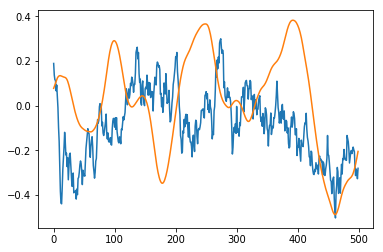

500
0.0656845848295
1.19143880717

El input al que comparamos es tau=10


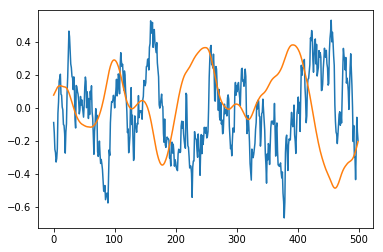

500
0.0367591922212
1.68557260765

TUBB1
El input al que comparamos es tau=20


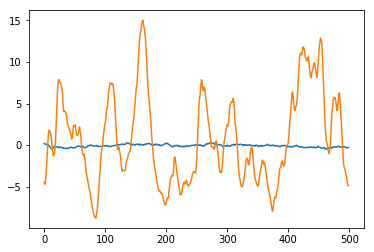

500
0.0398351225855
1.02209946596

El input al que comparamos es tau=10


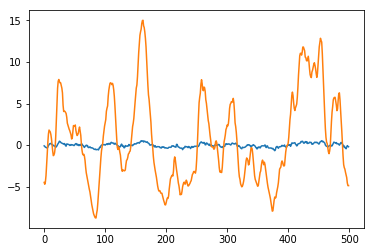

500
0.12654603426
0.974162921772

SPHK1
El input al que comparamos es tau=20


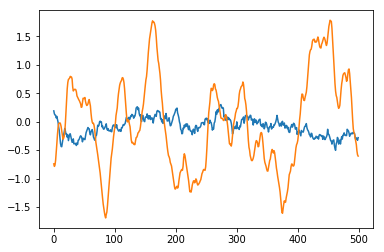

500
0.0465130462828
1.06921108964

El input al que comparamos es tau=10


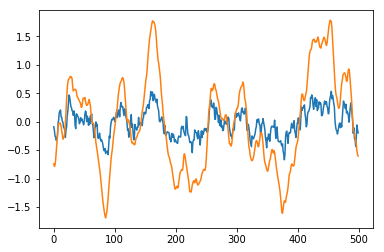

500
0.119512474915
0.757198950579

seed: 0
network_edge_list_ENCODE.csv
500
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.01, 0.01]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.5
Generating 20 noise


KeyboardInterrupt: 

In [38]:
#np.random.seed(22) dentro, np.random.seed(0) fuera
#np.random.seed(42) dentro, np.random.seed(6) fuera
i_scaling=[1,1]
beta_scaling=[0.01,0.01]
tau_list=[20,10]
for seed in range(0,30):
    for tau_train,tau_test in zip([10,20],[[10],[20]]):
        print("seed:", seed)
        np.random.seed(seed)
        test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.5, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,5, noise=True, euler=True, save=False, notebook=True)


network_edge_list_ENCODE.csv
500
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.01, 0.01]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.95
Generating 20 noise
Generating 10 noise
Generating 30 noise
Autocorrelation of generated noise
20
[  1.03281951  29.62593263  -0.06836178]


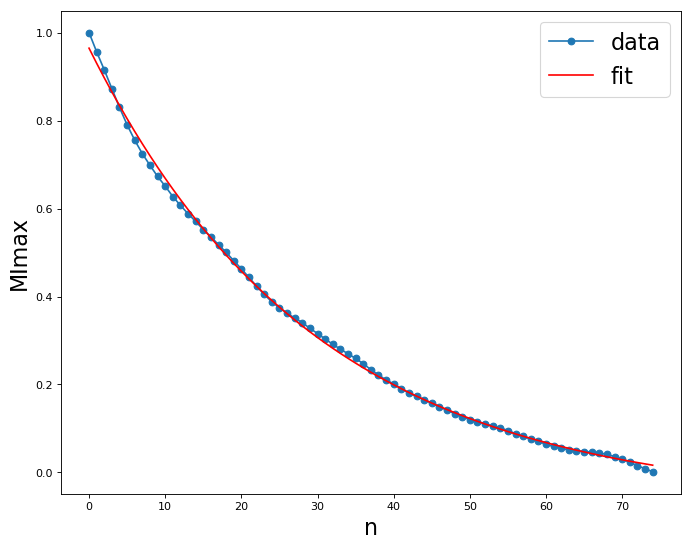

10
[ 1.01637122  8.71908207  0.01307606]


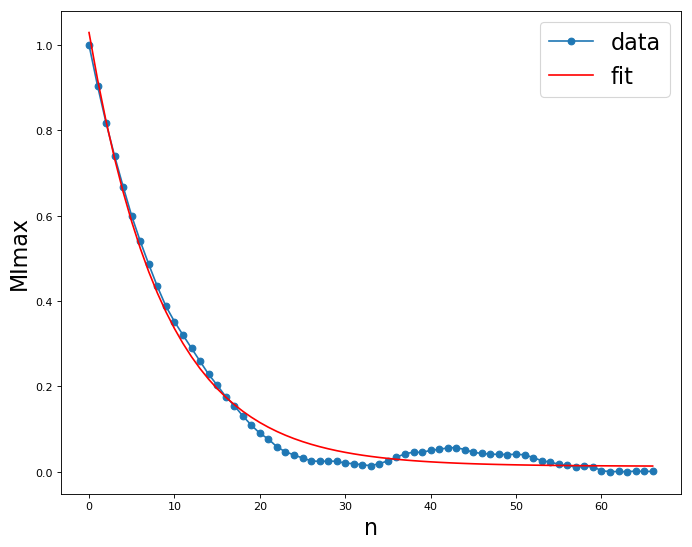

El traning se hace para 20 y en el testing introducimos las taus en 20
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 20 (input tau 20)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 20 (input tau 20)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 20 (input tau 20)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 20 (input tau 20)
BRD9 output being calcula

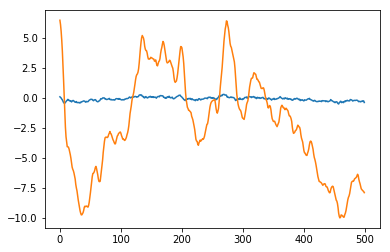

500
0.111471964632
1.08608928579

El input al que comparamos es tau=10


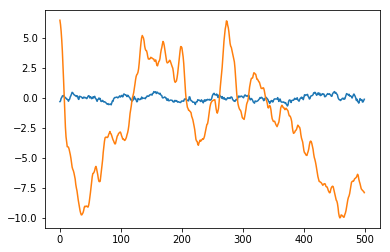

500
0.0371598723733
1.1319752357

TMEM14C
El input al que comparamos es tau=20


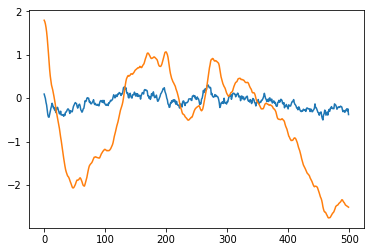

500
0.0669433892115
0.992981199453

El input al que comparamos es tau=10


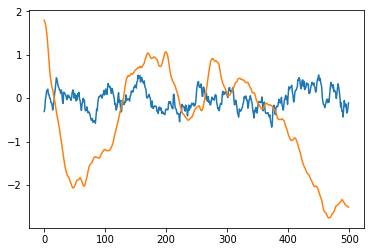

500
0.0362203849622
1.15145666385

C20orf111
El input al que comparamos es tau=20


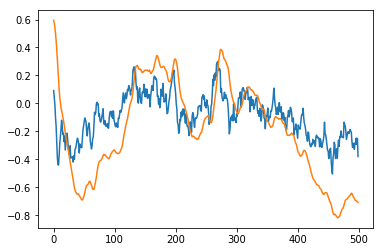

500
0.0820998384435
0.780498470171

El input al que comparamos es tau=10


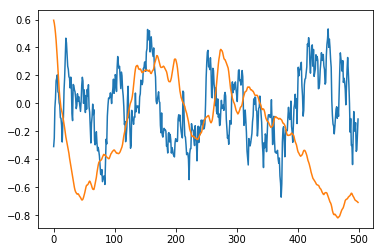

500
0.0410389014526
1.40322819999

STYXL1
El input al que comparamos es tau=20


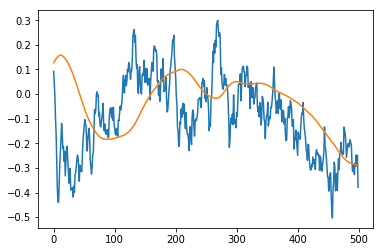

500
0.0586844987183
1.57099076015

El input al que comparamos es tau=10


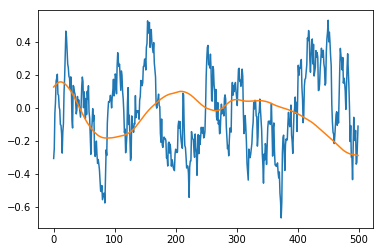

500
0.0396670599396
2.46099345932

BRD9
El input al que comparamos es tau=20


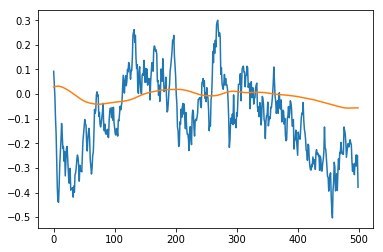

500
0.0578686154323
7.39117022794

El input al que comparamos es tau=10


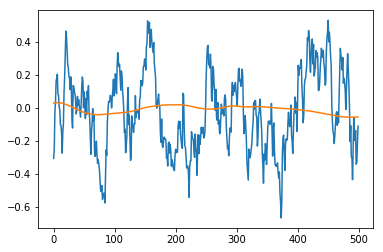

500
0.0322370239569
10.5090933918

ABCA3
El input al que comparamos es tau=20


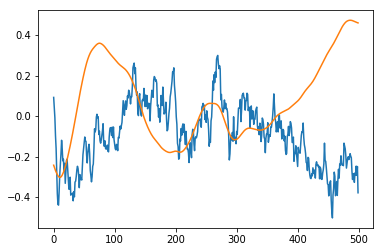

500
0.0566391850073
1.65734226197

El input al que comparamos es tau=10


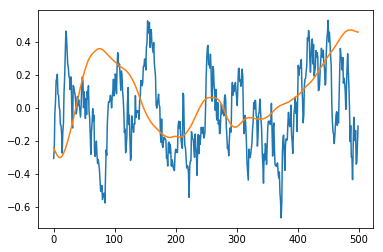

500
0.0383675353064
1.53541105881

ACAD9
El input al que comparamos es tau=20


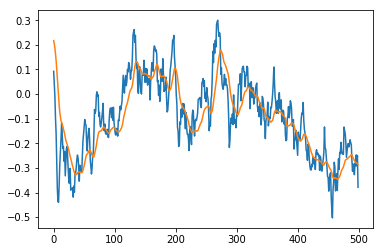

500
0.100217052234
0.6913016815

El input al que comparamos es tau=10


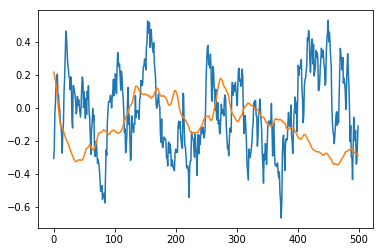

500
0.0414045387584
2.22286128906

ALDH1A1
El input al que comparamos es tau=20


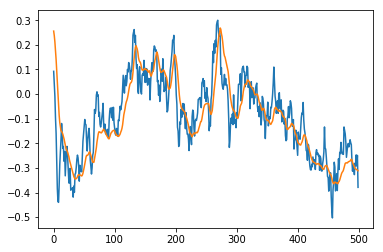

500
0.110415514202
0.592738362295

El input al que comparamos es tau=10


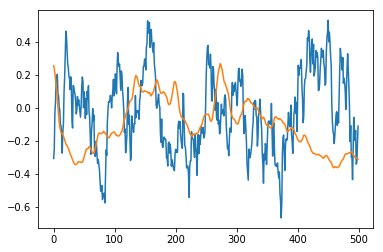

500
0.0384841053865
2.02879458134



(<__main__.ESN at 0x7f499e72b978>,
 {'ABCA3': 0.056639185007261832,
  'ACAD9': 0.10021705223360777,
  'ALDH1A1': 0.1104155142022403,
  'BRD9': 0.057868615432277358,
  'C20orf111': 0.082099838443498732,
  'STYXL1': 0.058684498718255346,
  'TMEM14C': 0.066943389211480922,
  'ZNF775': 0.11147196463221437},
 {'ABCA3': 1.6573422619660187,
  'ACAD9': 0.69130168149999505,
  'ALDH1A1': 0.59273836229475307,
  'BRD9': 7.391170227940945,
  'C20orf111': 0.78049847017124874,
  'STYXL1': 1.5709907601457267,
  'TMEM14C': 0.9929811994527542,
  'ZNF775': 1.0860892857896405})

In [38]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,0, noise=True, euler=True, save=False, notebook=True)


In [ ]:
nets={}
for tau_train in [20,10]:
    net=test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,0, noise=True, euler=True, save=False, notebook=True)


In [ ]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=10
 

In [ ]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)


In [ ]:
## SIMULACION 2

In [71]:
i_scaling=[1,1]
beta_scaling=[0.01,0.01]
tau_list=[20,10]
mi_histogram={}
nrmse_histogram={}
nets={}

for tau_train,tau_test in zip([10,20,10,20],[[10],[20],[30],[30]]):
    print(tau_train, "tau_train", tau_test, "tau_test")
    #np.random.seed(42)
    nets[(tau_train,tau_test[0])], mi_histogram[(tau_train,tau_test[0])],nrmse_histogram[(tau_train,tau_test[0])]=test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

10 tau_train [10] tau_test
network_edge_list_ENCODE.csv
990
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.01, 0.01]
[1, 1]
GO:0051591 20
GO:0070317 10
[0.00030387059696836859, 0.0, 0.0057060974663882972]
SR 0.95
Generating 20 noise
Generating 10 noise
Generating 30 noise


MemoryError: 

In [ ]:
miLen

In [ ]:
calc_MI_binning(net.u_dict[10][trainLen-n:trainLen+miLen-n], net.Y[3,0:miLen])
plot(net.u_dict[10][trainLen-n:trainLen+miLen-n])
plot(net.Y[3,0:miLen])
show()

In [ ]:
def memory_capacity_n(Yt, Xt,startLen,miLen,i_max,n_max):
    MI_i={}
    for i in range(i_max+1):
        MI_i[i]=calc_MI_binning(Xt[startLen+n_max-i:startLen+n_max+miLen-i],Yt[7,n_max:miLen+n_max]) 
    return MI_i


In [ ]:
max(memory_capacity_n(net.Y,net.u_dict[10],trainLen,miLen,i_max,n_max),key=memory_capacity_n(net.Y,net.u_dict[10],trainLen,miLen,i_max,n_max).get)

In [57]:
from matplotlib import colors as mcolors
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('font', family='serif')
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [68]:
readout_name= {
    2:"C20orf111",
    3:"STYXL1",
    6:"ACAD9"
}

['C20orf111', 'STYXL1', 'ACAD9']
[0.11740011491917664, 0.054826167808273027, 0.12767144592136734]


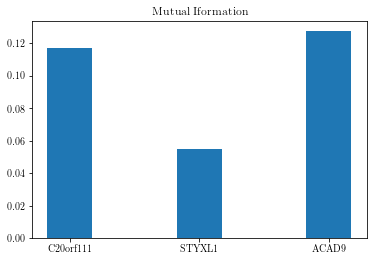

[0.050024676607102983, 0.066473218097717113, 0.082114256016569437]


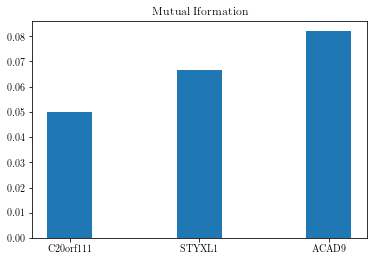

In [42]:
names=list(readout_name.values())
print(names)
ind=np.arange(len(readout_name))
for i,key in enumerate([(20,20),(10,10)]):
    bar(ind,[mi_histogram[key][name_r] for name_r in names],width=0.35)
    #ylabel('Genes')
    title('Mutual Iformation')
    xticks(ind, names)
    #yticks(np.arange(0, 81, 10))
    print([mi_histogram[key][name_r] for name_r in names])
    show()

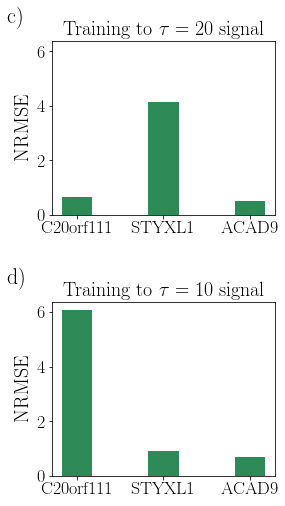

In [157]:
n=10
names=list(readout_name.values())
ind=np.arange(len(readout_name))
letter= {0:"c)",1:"d)"}
colors_bar=["goldenrod","dodgerblue","green"]
fig, axes = subplots(nrows=2, ncols=1, sharex=False, sharey=True, figsize=(4, 8))
#fig.text(0.5, 0.05, 'time', ha='center',fontsize=60)
print(axes)
subplots_adjust(hspace=0.5)
#for i,net in enumerate([nets[(20,20)],nets[(10,10)]]):
axes[0].set_title('Mutual Iformation',fontsize=21)
for i,key in enumerate([(20,20),(10,10)]):
    axes[i].set_title(r'Training to $\tau={}$ signal'.format(key[0],n),fontsize=20)
    axes[i].set_ylabel('NRMSE',fontsize=20)
    axes[i].tick_params(axis='both', labelsize=18)
    axes[i].text(-0.2, 1.1,letter[i], transform= axes[i].transAxes, size=22)       
    barlist=axes[i].bar(ind,[nrmse_histogram[key][name_r] for name_r in names],width=0.35,tick_label=names,color="seagreen")
    
    
show()

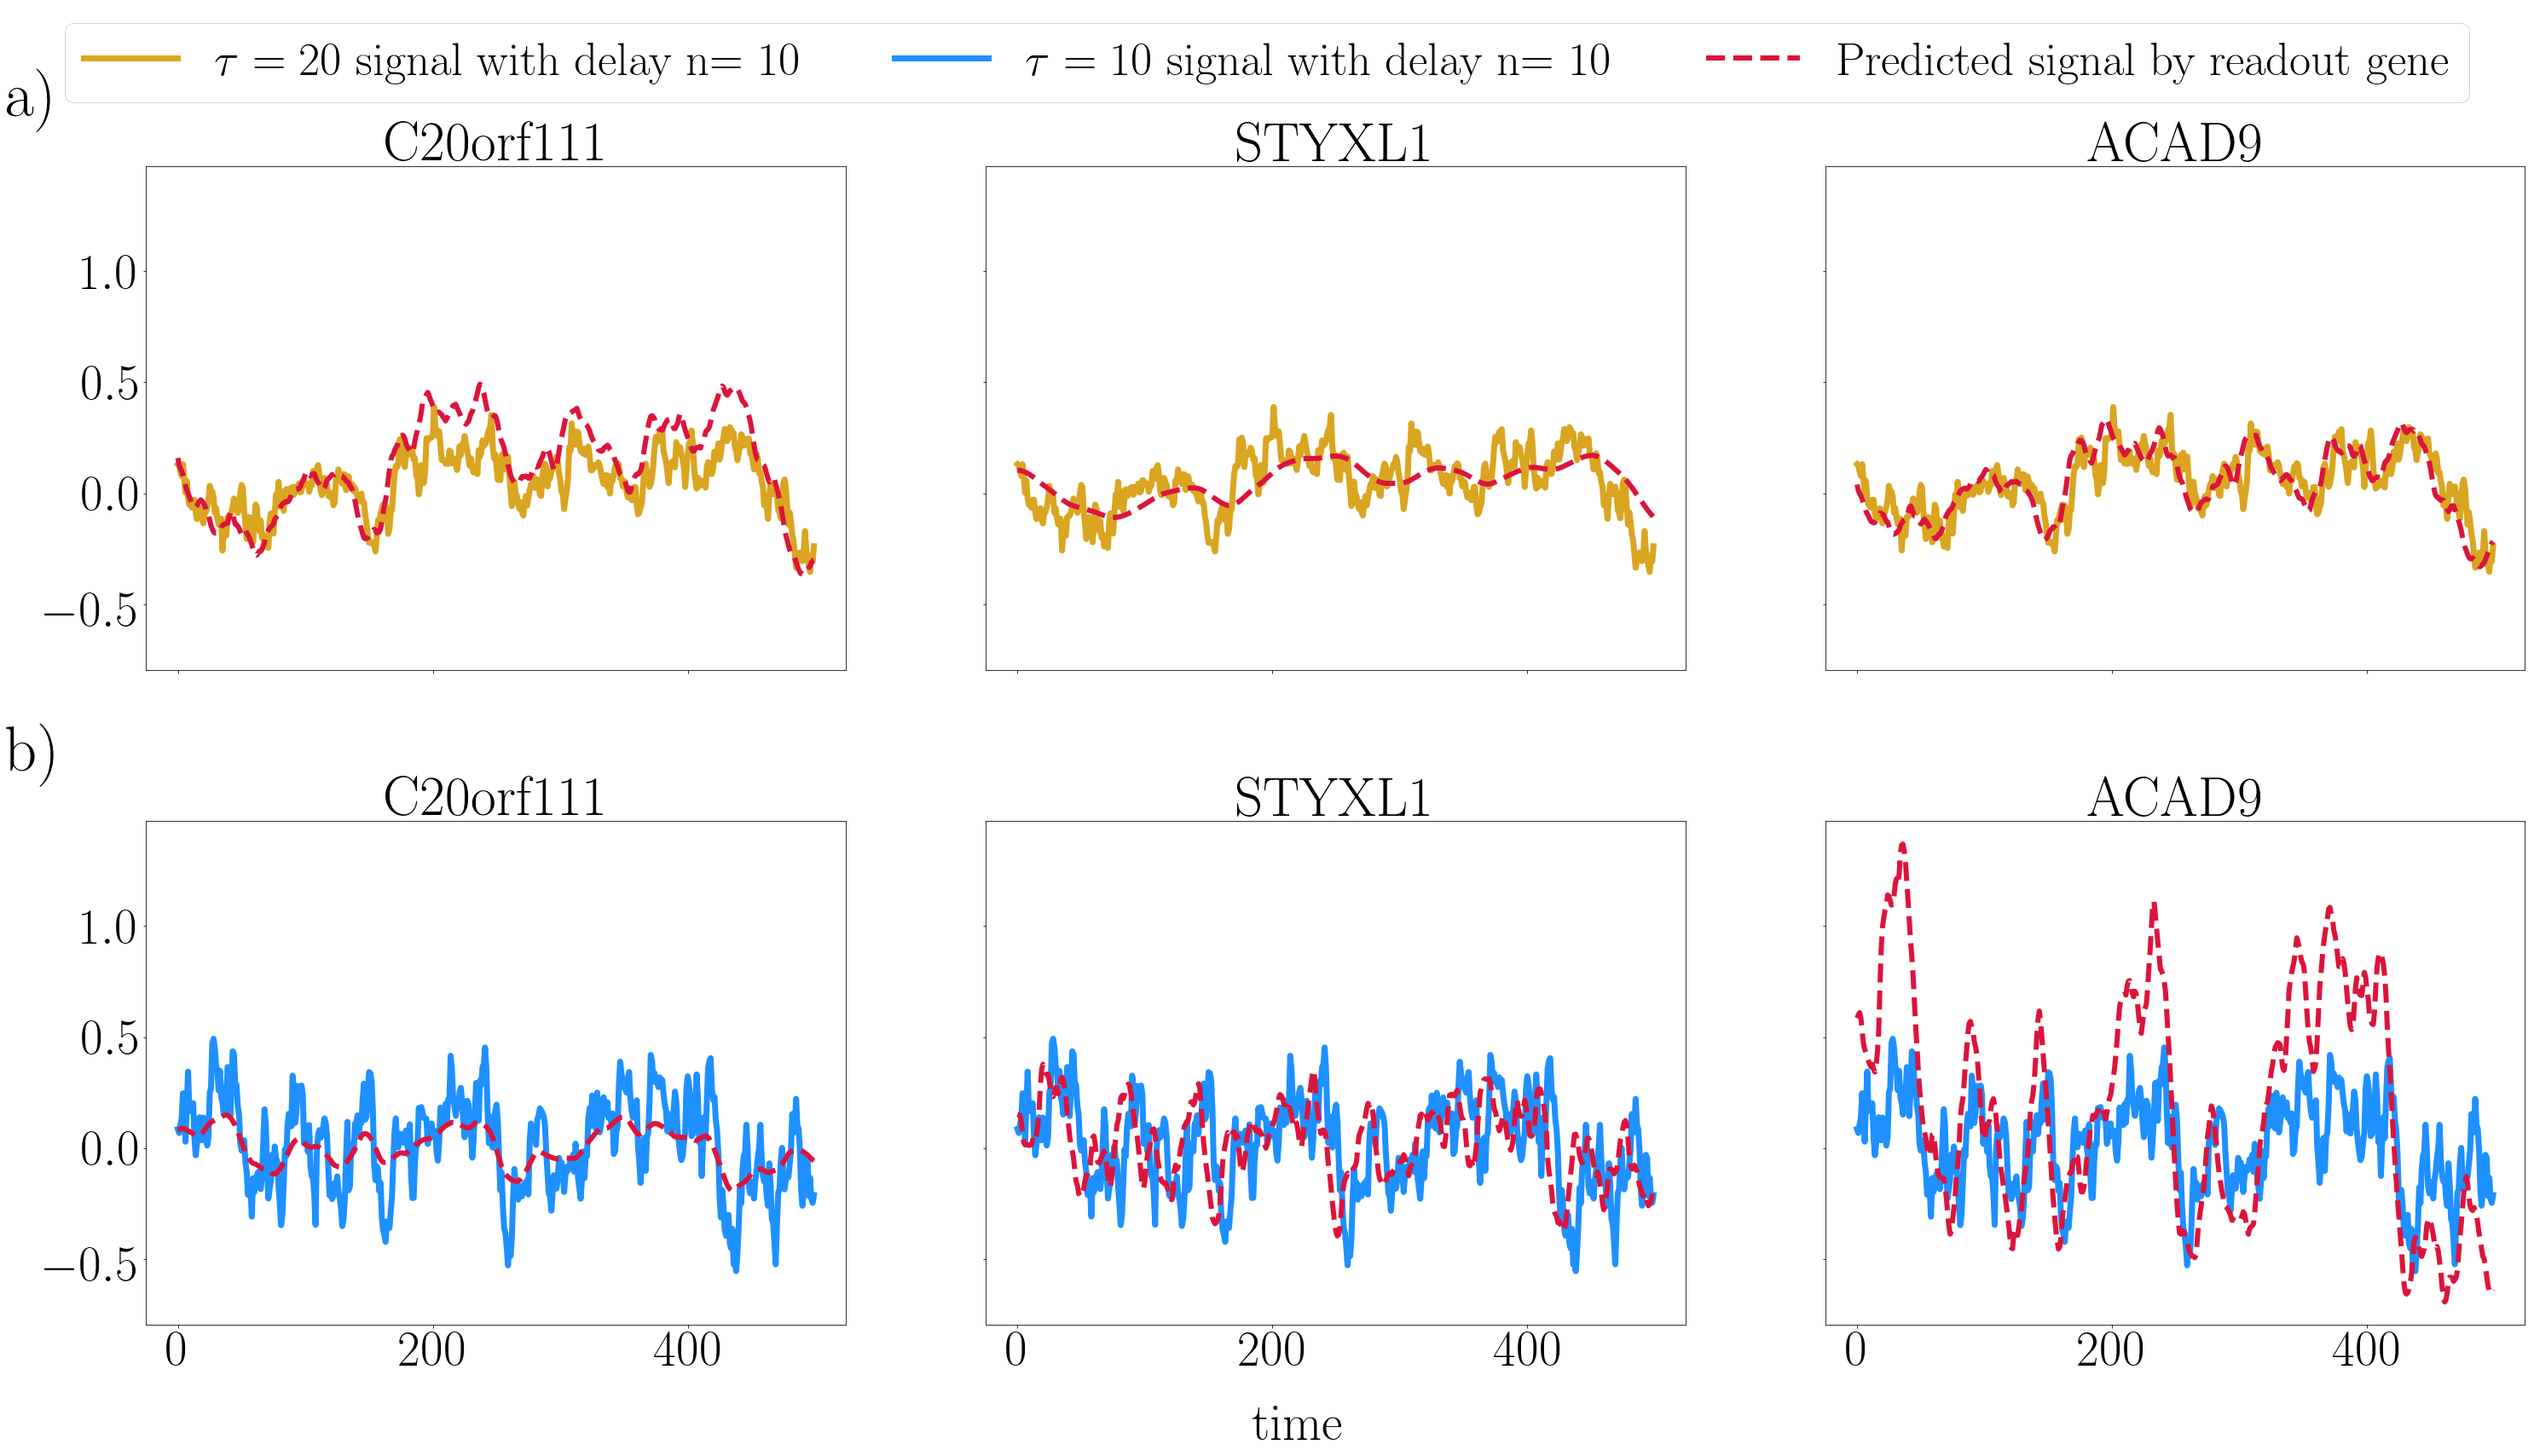

In [69]:

n=10
tau_net= {
    0:(20,"a)","goldenrod"),
    1:(10, "b)",'dodgerblue')
}
fig, axes = subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(50, 25))
fig.text(0.5, 0.05, 'time', ha='center',fontsize=60)
subplots_adjust(hspace=0.3)
#for i,net in enumerate([nets[(20,20)],nets[(10,10)]]):
for i,key in enumerate([(20,20),(10,10)]):
    net=nets[key]
    axes[i,0].text(-0.2, 1.1, tau_net[i][1], transform= axes[i,0].transAxes, size=75)       
    for j,readout_pos in enumerate([2,3,6]):
        ax1=axes[i,j]
        ax1.set_title(readout_name[readout_pos],fontsize=65)
        
        if i==0:
            h1=ax1.plot( net.u_dict[tau_net[i][0]][0+trainLen-n:trainLen+500-n], color=colors[tau_net[i][2]],linewidth=7 )
        else:
            h3=ax1.plot( net.u_dict[tau_net[i][0]][0+trainLen-n:trainLen+500-n], color=colors[tau_net[i][2]],linewidth=7 )
        h2=ax1.plot(net.Y[readout_pos,0:500],"--", color=colors['crimson'],linewidth=6 )
        #ax1.legend(['Noise signal with delay n= {}'.format(n), "Predicted signal"],fontsize=18)
        ax1.tick_params(axis='both', labelsize=58)
    #axes[i,0].legend(['Noise signal with delay n= {}'.format(n), "Predicted signal"],fontsize=50,bbox_to_anchor=(0.8,1.2))

    
    #axes[i,3].set_xticks(ind, names)
    #yticks(np.arange(0, 81, 10))
    #print([mi_histogram[key][name_r] for name_r in names])

figlegend([h1[0],h3[0],h2[0]],[r'$\tau=20$ signal with delay n= {}'.format(n), r'$\tau=10$ signal with delay n= {}'.format(n),"Predicted signal by readout gene"],fontsize=55,ncol=3,loc="upper center")    
show()

In [ ]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=20

In [ ]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

In [ ]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=20

In [ ]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,0, noise=True, euler=True, save=False, notebook=True)

In [ ]:
i_scaling=[1,0]
beta_scaling=[0.05,0.05]
tau_list=[1,5]
tau_test=[1,5,sum(tau_list)]
tau_train=6

In [ ]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

In [ ]:
## SIMULACIONES CON UN INPUT

In [ ]:
i_scaling=[0,1]

In [ ]:
test("Dataset1",file, 2, 1,i_scaling,beta_scaling,['GO:0070317', 'GO:0051591'],0, noise=True)

In [ ]:
#Save dictionary
i_scaling=0.05
beta_scaling=0.05
MI_GOterm={}
for GOterm in GO_id_map.keys():
    print(GOterm)
    mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,GOterm,0, noise=True)
    MI_GOterm[GOterm]={
        "mi_go":mi_go_by_gene,
        "mi_not_go":mi_not_go
    }

In [ ]:
beta_scaling=1
for i_scaling in [100,0,1,0.05]:
    mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,"GO:0006337",0, noise=True)
    mi_mean=np.mean(list(mi_go_by_gene.values()))
    print("Mean MI Genes with GOterm: {:.3}".format(mi_mean))
    not_mi_mean=np.mean(mi_not_go)
    print("Mean MI Genes without GOterm:{:.3}".format(not_mi_mean))
    for el in sorted(mi_go_by_gene, key=mi_go_by_gene.get, reverse=True):
        print("{0:>15} {1:>5} {2:>5} {3:>5}  {4:{width}{numbers}}\n".format(el[0],el[1],G.in_degree(el[0]),G.out_degree(el[0]), mi_go_by_gene[el],width=5,numbers=".2"))

In [ ]:
import pandas
pandas.Series(np.array([0,1,2,2])).value_counts()

In [ ]:
i_scaling=0.05
mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,"GO:0006337",0, noise=True)

In [ ]:
##TABLA CON DEGREES
width=8
out_file=open("go_mi.txt","w")
for key in MI_GOterm.keys():
    out_file.write(key+"\n")
    for el in sorted(MI_GOterm[key]["mi_go"], key=MI_GOterm[key]["mi_go"].get, reverse=True):
        out_file.write("{0:>15} {1:>5} {2:>5} {3:>5}{4:{width}{numbers}}\n".format(el[0],el[1],G.in_degree(el[0]),G.out_degree(el[0]), MI_GOterm[key]["mi_go"][el],width=width,numbers=".2"))

In [ ]:
dictionary = {'hello':'world'}
np.save('mi_i_scaling{}.npy'.format(i_scaling), MI_GOterm) 


In [ ]:
MI_GOterm_from_file=MI_GOterm

In [ ]:
# Load
MI_GOterm_from_file = np.load('mi_i_scaling{}.npy').item()

In [ ]:
## TABLA CON MEDIAS
for key in MI_GOterm_from_file.keys():
    
    mi_mean=np.mean(list(MI_GOterm_from_file[key]["mi_go"].values()))
    #print("Mean MI Genes with GOterm: {:.3}".format(mi_mean))
    not_mi_mean=np.mean(MI_GOterm_from_file[key]["mi_not_go"])
    #print("Mean MI Genes without GOterm:{:.3}".format(not_mi_mean))
    print("{0:>5}{1:{width}{numbers}}{2:{width}{numbers}}".format(key,mi_mean, not_mi_mean,width=15, numbers=".2"))

In [ ]:
indexes=list(range(0,2))+[index+2+1 for index in range(0,5)]
indexes